In [93]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import neurokit2 as nk
import scipy.signal as signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# DEMOSTRACION DE MODELO MLP -- LATIDOS ANORMALES

In [95]:
# CARGA DE MODELO
class ECGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

model = ECGNet(input_size=187, num_classes=5).to(device)
model.load_state_dict(torch.load("ecg_model.pth", map_location=device))
model.eval()
print("Modelo cargado correctamente")

Modelo cargado correctamente


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\4287592573.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_model.pth", map_locat

In [96]:

df = pd.read_csv("ptbdb_abnormal.csv", header=None)
signal_raw = df.iloc[:,0].values.astype(np.float32)

fs = 125 
lowcut = 0.5
highcut = 40.0
order = 4
b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
signal_filtered = signal.filtfilt(b, a, signal_raw)
notch_freq = 50.0
Q = 30.0
b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)

signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
r_peaks = info["ECG_R_Peaks"]

segments = []
for r in r_peaks:
    start = r - 93
    end = r + 94
    if start >= 0 and end <= len(signal_filtered):
        segments.append(signal_filtered[start:end])

scaler = StandardScaler()
segments_scaled = scaler.fit_transform(np.array(segments))

print(segments_scaled)

X = torch.tensor(segments_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    outputs = model(X)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

[[ 0.35788195  1.75073741  2.26492664 ...  0.31423307 -0.99515814
   0.30538636]
 [-1.51712795 -0.61016935  0.77260161 ...  0.3018632   0.4025816
   0.09320773]
 [-0.20649649 -0.69155798  0.3438492  ... -0.58598318 -0.29935482
  -0.66072582]
 ...
 [-0.98538139 -0.02115281  0.70467851 ...  0.85052911 -0.27599848
  -0.67074894]
 [ 1.02365284 -0.04419813 -0.3158538  ...  0.93661867  0.99627249
   1.67971966]
 [-0.20323096  0.37611759  0.81975823 ...  0.35550276  1.13801347
   1.79689412]]


In [97]:
print("Predicciones realizadas.")
print("Conteo por clase:", np.bincount(predictions))

Predicciones realizadas.
Conteo por clase: [65  5  3  1  3]


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\2378732560.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


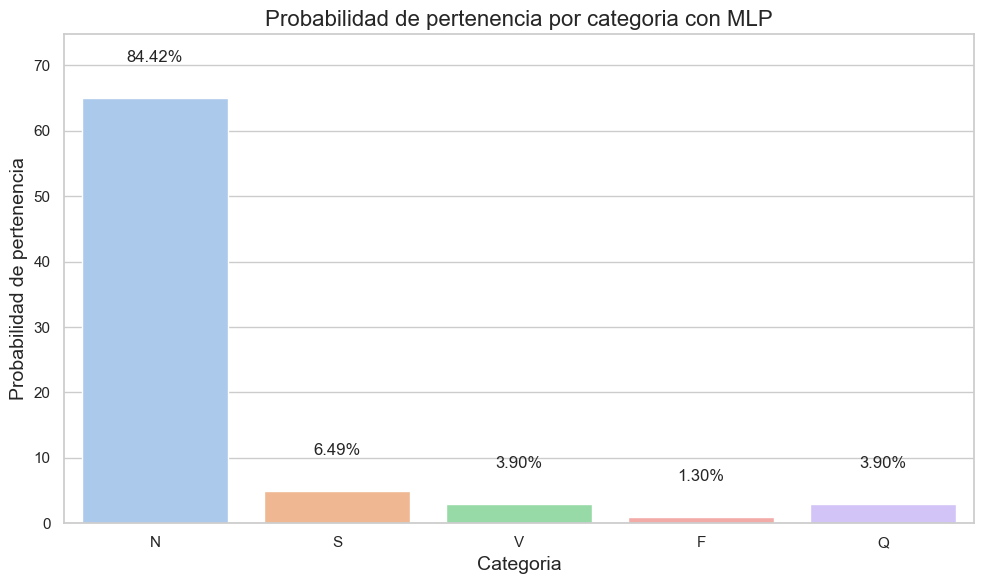

In [98]:
class_labels = ['N', 'S', 'V', 'F', 'Q']

counts = np.bincount(predictions, minlength=5) 
total = counts.sum()
probabilities = counts / total

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=class_labels, y=counts, palette="pastel")

for i, (count, prob) in enumerate(zip(counts, probabilities)):
    plt.text(i, count + 5, f"{prob:.2%}", ha='center', va='bottom', fontsize=12)

plt.title("Probabilidad de pertenencia por categoria con MLP", fontsize=16)
plt.xlabel("Categoria", fontsize=14)
plt.ylabel("Probabilidad de pertenencia", fontsize=14)
plt.ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# DEMOSTRACION DE MODELO CNN -- LATIDOS ANORMALES

In [99]:
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        conv_output_length = 187 // 4
        self.fc1 = nn.Linear(32 * conv_output_length, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))        
        return self.fc2(x)
    
model = ECGCNN(num_classes=5).to(device)
model.load_state_dict(torch.load("ecg_model_cnn.pth", map_location=device))
model.eval()
print("Modelo CNN cargado correctamente.")


Modelo CNN cargado correctamente.


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\1703415733.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_model_cnn.pth", map_l

In [100]:
# DEMOSTRACION DE MODELO -- LATIDOS ANORMALES
df = pd.read_csv("ptbdb_abnormal.csv", header=None)
signal_raw = df.iloc[:,0].values.astype(np.float32)
fs = 125 
lowcut = 0.5
highcut = 40.0
order = 4
b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
signal_filtered = signal.filtfilt(b, a, signal_raw)
notch_freq = 50.0
Q = 30.0
b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)

signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
r_peaks = info["ECG_R_Peaks"]

segments = []
for r in r_peaks:
    start = r - 93
    end = r + 94
    if start >= 0 and end <= len(signal_filtered):
        segments.append(signal_filtered[start:end])

scaler = StandardScaler()
segments_scaled = scaler.fit_transform(np.array(segments))

print(segments_scaled)

X = torch.tensor(segments_scaled, dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    outputs = model(X)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

[[ 0.35788195  1.75073741  2.26492664 ...  0.31423307 -0.99515814
   0.30538636]
 [-1.51712795 -0.61016935  0.77260161 ...  0.3018632   0.4025816
   0.09320773]
 [-0.20649649 -0.69155798  0.3438492  ... -0.58598318 -0.29935482
  -0.66072582]
 ...
 [-0.98538139 -0.02115281  0.70467851 ...  0.85052911 -0.27599848
  -0.67074894]
 [ 1.02365284 -0.04419813 -0.3158538  ...  0.93661867  0.99627249
   1.67971966]
 [-0.20323096  0.37611759  0.81975823 ...  0.35550276  1.13801347
   1.79689412]]


In [101]:
print("Predicciones realizadas.")
print("Conteo por clase:", np.bincount(predictions))

Predicciones realizadas.
Conteo por clase: [ 7 58 12]


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\1709528067.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


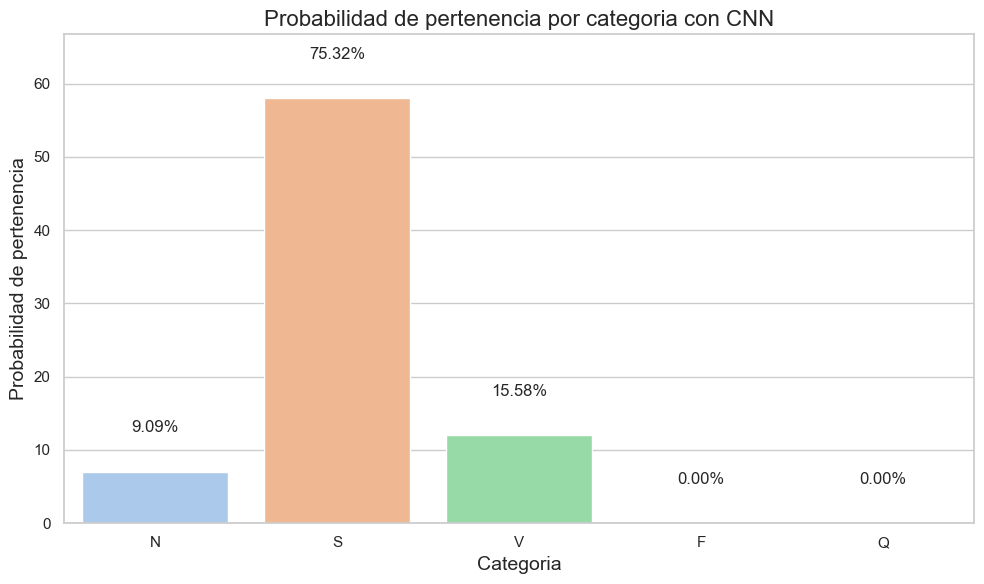

In [102]:
class_labels = ['N', 'S', 'V', 'F', 'Q']

counts = np.bincount(predictions, minlength=5) 
total = counts.sum()
probabilities = counts / total

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=class_labels, y=counts, palette="pastel")

for i, (count, prob) in enumerate(zip(counts, probabilities)):
    plt.text(i, count + 5, f"{prob:.2%}", ha='center', va='bottom', fontsize=12)

plt.title("Probabilidad de pertenencia por categoria con CNN", fontsize=16)
plt.xlabel("Categoria", fontsize=14)
plt.ylabel("Probabilidad de pertenencia", fontsize=14)
plt.ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# EXPERIMENTO

In [103]:
def cargar_y_filtrar(input_file, fs, lowcut=0.5, highcut=40.0, notch_freq=50.0, Q=30.0, order=4):
    #Carga señal ECG desde archivo CSV, aplica filtro banda y filtro notch.
    #Devuelve DataFrame original y la señal filtrada.

    df = pd.read_csv(input_file, sep=';', parse_dates=['Timestamp'])
    signal_raw = df['ECG_Value'].values.astype(np.float32)
    
    # Filtro banda
    b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    signal_filtered = signal.filtfilt(b, a, signal_raw)

    # Filtro notch
    b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
    signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)

    return df, signal_filtered

def detectar_r_peaks(signal_filtered, fs):
    # Devuelve índices de los R peaks detectados en la señal filtrada.    
    signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]
    return r_peaks

def guardar_con_picos(df, signal_filtered, r_peaks, output_file):
    # Guarda CSV con señal filtrada y columna indicando presencia de R peak.   
    df['Filtered_ECG'] = signal_filtered
    df['R_Peak'] = 0
    df.loc[r_peaks, 'R_Peak'] = 1
    df.to_csv(output_file, sep=';', index=False)
    print(f"Archivo con R Peaks guardado: {output_file}")

def segmentar_senal(signal_filtered, segment_length, output_segments_file):
    # Segmenta la señal en ventanas de longitud fija y guarda en CSV.
    num_segments = len(signal_filtered) // segment_length
    signal_trimmed = signal_filtered[:num_segments * segment_length]
    signal_segments = signal_trimmed.reshape(num_segments, segment_length)
    np.savetxt(output_segments_file, signal_segments, delimiter=',', fmt='%.6f', header='', comments='')
    print(f"Archivo de segmentos guardado: {output_segments_file}")
    return signal_segments

def predecir(model, signal_segments, device):
    # Predice categorías usando el modelo CNN.
    # Devuelve array de predicciones.    
    X = torch.tensor(signal_segments.copy(), dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    return predictions

def graficar_predicciones(predictions, class_labels):
    # Muestra un gráfico de barras de las predicciones.
    counts = np.bincount(predictions, minlength=len(class_labels))
    total = counts.sum()
    probabilities = counts / total

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=class_labels, y=counts, palette="pastel")

    for i, (count, prob) in enumerate(zip(counts, probabilities)):
        plt.text(i, count + 5, f"{prob:.2%}", ha='center', va='bottom', fontsize=12)

    plt.title("Resultados experimento -- Primera parte (CNN)", fontsize=16)
    plt.xlabel("Categoría", fontsize=14)
    plt.ylabel("Datos asignados", fontsize=14)
    plt.ylim(0, max(counts) * 1.15)
    plt.tight_layout()
    plt.show()


## PRIMERA PARTE - RESULTADOS

Archivo con R Peaks guardado: ecg_data_filtrada_con_picos.csv
Archivo de segmentos guardado: ecg_segmentado_187.csv


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\151443706.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


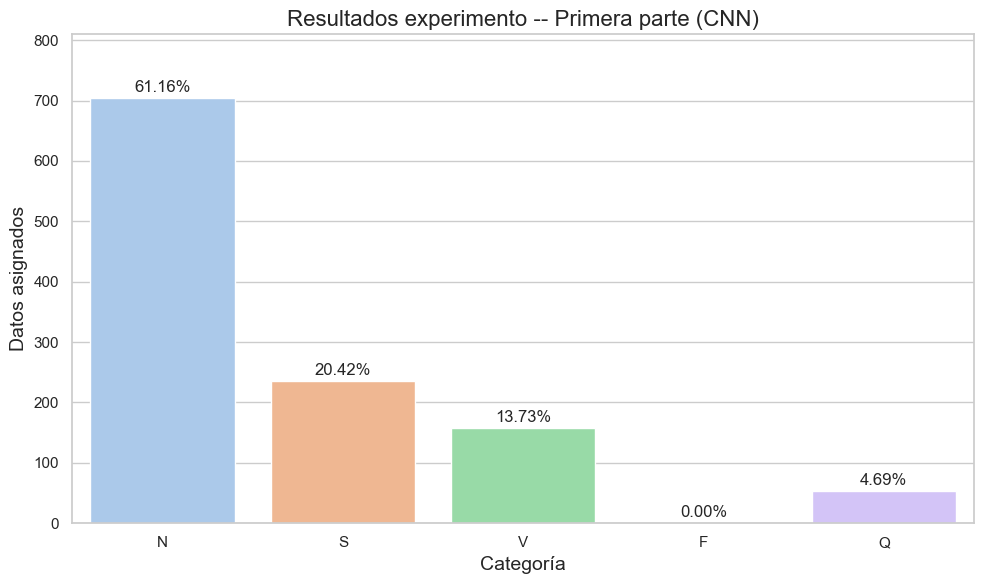

In [104]:
fs = 125
input_file = "ecg_data_5.csv"
output_file = "ecg_data_filtrada_con_picos.csv"
output_segments_file = "ecg_segmentado_187.csv"
segment_length = 187
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = ['N', 'S', 'V', 'F', 'Q']

df, signal_filtered = cargar_y_filtrar(input_file, fs)

r_peaks = detectar_r_peaks(signal_filtered, fs)

guardar_con_picos(df, signal_filtered, r_peaks, output_file)

signal_segments = segmentar_senal(signal_filtered, segment_length, output_segments_file)

predictions = predecir(model, signal_segments, device)

graficar_predicciones(predictions, class_labels)


## SEGUNDA PARTE - RESULTADOS

Archivo con R Peaks guardado: ecg_data_filtrada_con_picos_2.csv
Archivo de segmentos guardado: ecg_segmentado_187_2.csv


C:\Users\matia\AppData\Local\Temp\ipykernel_23016\151443706.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


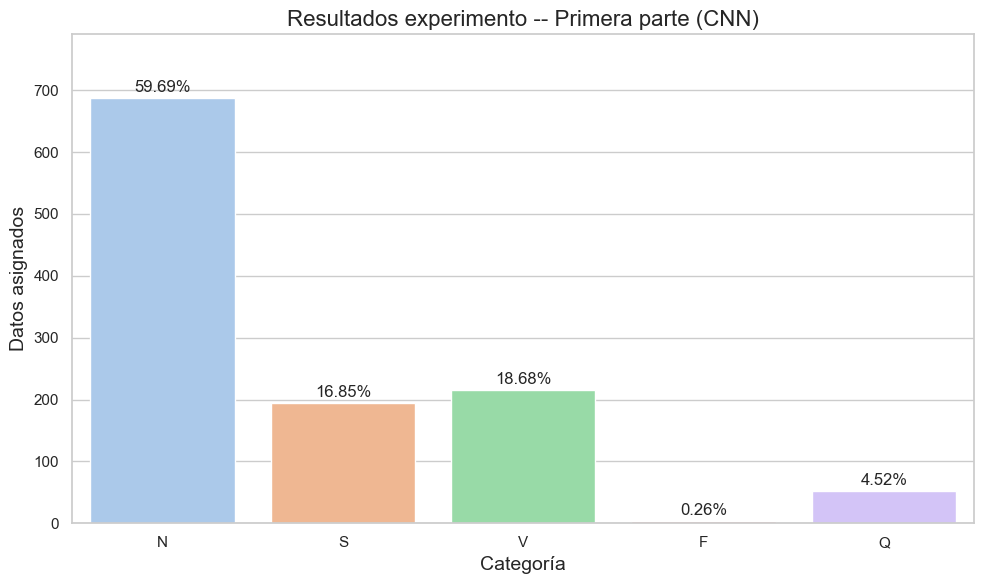

In [106]:
fs = 125
input_file = "ecg_data_6.csv"
output_file = "ecg_data_filtrada_con_picos_2.csv"
output_segments_file = "ecg_segmentado_187_2.csv"
segment_length = 187
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = ['N', 'S', 'V', 'F', 'Q']

df, signal_filtered = cargar_y_filtrar(input_file, fs)

r_peaks = detectar_r_peaks(signal_filtered, fs)

guardar_con_picos(df, signal_filtered, r_peaks, output_file)

signal_segments = segmentar_senal(signal_filtered, segment_length, output_segments_file)

predictions = predecir(model, signal_segments, device)

graficar_predicciones(predictions, class_labels)